# End-to-End.

In [1]:
import os
import io
import json
import re
import warnings

import minio
import numpy as np
import pandas as pd
from minio import Minio
from IPython.display import Image
from pymongo import MongoClient
from pyspark.sql import SparkSession
from transformers import pipeline

In [2]:
warnings.filterwarnings("ignore")

## Architektura.

Utwórz diagram prezentujacy architekturę systemu.

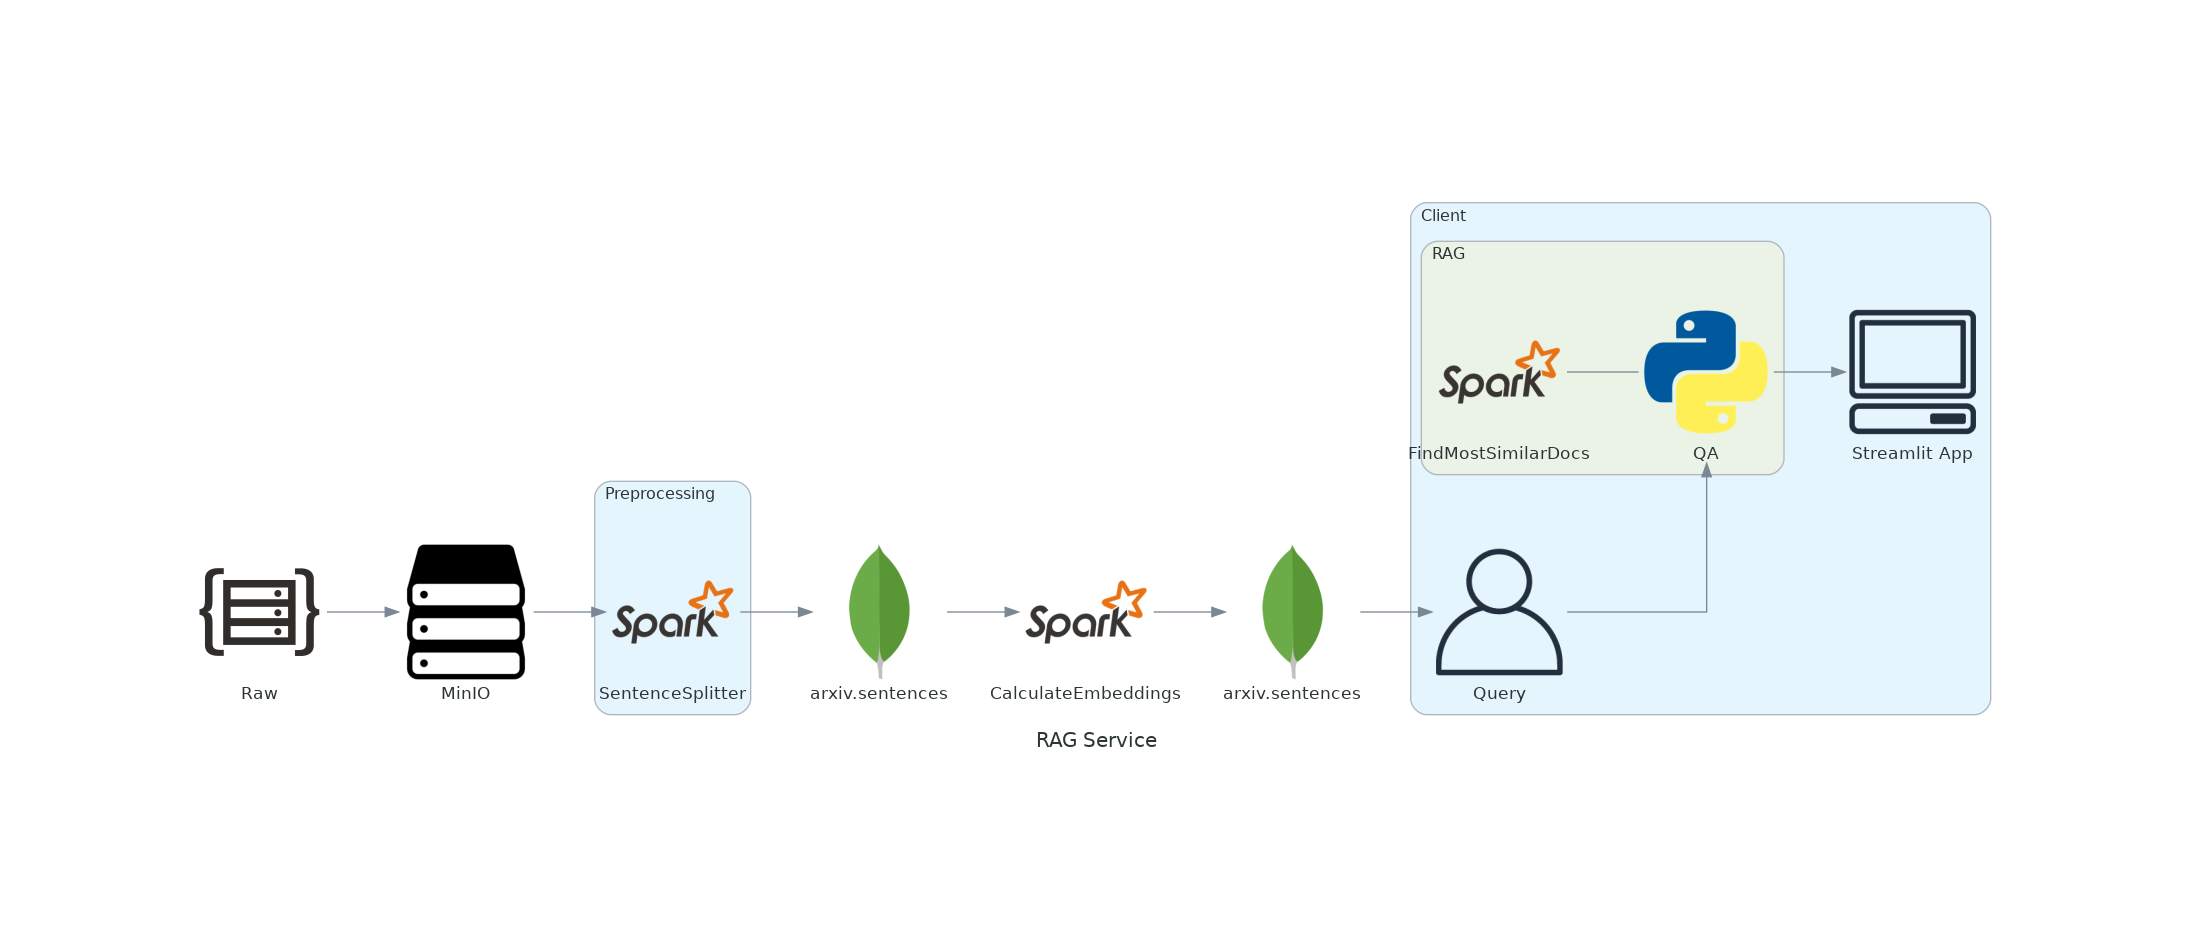

In [3]:
from diagrams import Diagram, Cluster
from diagrams.generic.storage import Storage
from diagrams.onprem.analytics import Spark
from diagrams.onprem.client import Client, User
from diagrams.onprem.database import Mongodb
from diagrams.oci.devops import ResourceMgmt as FileIcon
from diagrams.programming.language import Python


with Diagram("RAG Service", filename="rag", show=False,):

    with Cluster("Preprocessing"):
        preprocessing = [
            Spark("SentenceSplitter"),
        ]

    with Cluster("Client"):
        user = User("Query")
        with Cluster("RAG"):
            rag = Spark("FindMostSimilarDocs") - Python("QA")
        client = Client("Streamlit App")

    (
        FileIcon("Raw") >>
        Storage("MinIO") >>
        preprocessing >>
        Mongodb("arxiv.sentences") >>
        Spark("CalculateEmbeddings") >>
        Mongodb("arxiv.sentences") >>
        user >>
        rag >>
        client
    )

Image("rag.png")

## Pipeline.

### Preprocessing.

In [ ]:
import pyspark.sql.functions as F
from pyspark.sql.types import ArrayType, DoubleType, StringType

Inicjalizuj sesję Spark.

In [ ]:
%%capture cap --no-stderr
spark = (
    SparkSession
    .builder
    .master("spark://spark:7077")
    .appName("PySpark")
    .config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:3.3.4,com.amazonaws:aws-java-sdk-bundle:1.12.262,org.mongodb.spark:mongo-spark-connector_2.12:10.3.0")
    .config("spark.hadoop.fs.s3a.access.key", "minio")
    .config("spark.hadoop.fs.s3a.secret.key", "miniominio")
    .config("spark.hadoop.fs.s3a.endpoint", "http://minio:9000")
    .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem")
    .config("spark.hadoop.fs.s3a.connection.ssl.enabled", "false")
    .config("spark.hadoop.fs.s3a.path.style.access", "true")
    .config("spark.hadoop.fs.s3a.attempts.maximum", "1")
    .config("spark.hadoop.fs.s3a.connection.establish.timeout", "5000")
    .config("spark.hadoop.fs.s3a.connection.timeout", "50000")
    .config("spark.mongodb.read.connection.uri", "mongodb://mongo:27017")
    .config("spark.mongodb.write.connection.uri", "mongodb://mongo:27017")
    .config("spark.eventLog.gcMetrics.youngGenerationGarbageCollectors", "G1 Young Generation, ParNew")
    .config("spark.eventLog.gcMetrics.oldGenerationGarbageCollectors", "G1 Old Generation, ConcurrentMarkSweep")
    .config("spark.dynamicAllocation.enabled", "true")
    .config("spark.driver.memory", "8g")
    .config("spark.executor.memory", "2g")
    .config("spark.executor.instances", 2)
    .config("spark.executor.cores", 4)
    .config("spark.dynamicAllocation.minExecutors", 2)
    .config("spark.dynamicAllocation.maxExecutors", 8)
    .config("spark.memory.offHeap.enabled", "true")
    .config("spark.memory.offHeap.size", "2g")
    .getOrCreate()
)

Wczytaj dane z MinIO.

In [ ]:
%%time
data = spark.read.json("s3a://papers/*.json")

In [ ]:
data.count()

Podziel tekst abstraktów na pojedyncze zdania.

In [ ]:
split_text_to_sentences = F.udf(
    lambda x: list(map(str.strip, re.split(r'(?<=[.!?]) +', x))),
    ArrayType(StringType())
)
# Split the abstracts to the sentences.
data = data.withColumn("sentences", split_text_to_sentences(F.col("abstract")))
# Rename id with the _id, to create the key for the mongodb.
data = data.withColumnRenamed("id", "_id")

Przedstaw schemat.

In [ ]:
data.printSchema()

Zapisz potrzebne pola w MongoDB.

In [ ]:
%%time
(
    data
    .select(
        F.col("_id"),
        F.col("abstract").alias("full_text"),
        F.col("sentences"),
    )
    .write
    .format("mongodb")
    .option("database", "arxiv")
    .option("collection", "sentences")
    .mode("append")
    .save()
)

### Embeddings.

Wczytaj dane z MongoDB.

In [ ]:
data = (
    spark
    .read
    .format("mongodb")
    .option("database", "arxiv")
    .option("collection", "sentences")
    .load()
)

In [ ]:
data.printSchema()

In [ ]:
def setup_feature_extractor(
    model: str = "sentence-transformers/all-MiniLM-L6-v2",
) -> pipeline:
    """Setup feature extractor."""
    from sentence_transformers import SentenceTransformer

    return SentenceTransformer(model)


feature_extractor = setup_feature_extractor()

In [ ]:
@F.pandas_udf("array<array<double>>")
def calculate_embeddings(inputs: pd.Series) -> pd.DataFrame:
    return inputs.apply(
        lambda sentences: [
            feature_extractor.encode(sentence)
            for sentence in sentences
        ]
    )

In [ ]:
data = data.withColumn("embeddings", calculate_embeddings(F.col("sentences")))

Upsert Mongo.

In [ ]:
%%time
(
    data
    .write
    .format("mongodb")
    .option("database", "arxiv")
    .option("collection", "sentences")
    .option("replaceDocument", "false")
    .mode("append")
    .save()
)

In [ ]:
del data

### Similar Documents.

- `$vectorSearch` działa wyłacznie w MongoDB Atlas,
- zastępujemy `$vectorSearch` przez implementację algorytmu k-NN w `PySpark`,
- poprawa skalowalności:
    - https://spark.apache.org/docs/2.2.0/ml-features.html#approximate-nearest-neighbor-search,
    - https://github.com/LinkedInAttic/scanns

In [ ]:
data = (
    spark
    .read
    .format("mongodb")
    .option("database", "arxiv")
    .option("collection", "sentences")
    .load()
)

Explode: jeden rekord, jedno zdanie.

In [ ]:
data = (
    data
    .select(F.col("_id"), F.col("embeddings"))
    .withColumn("embeddings", F.explode(F.col("embeddings")))
)

Definiuj miarę podobieństwa.

In [ ]:
def cosine_similarity(v1, v2):
    return float(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))

Tekst przykładowego dokumentu.

```json
{
  "_id": "0704.0049",
  "full_text": "  We present an algorithm that produces the classification list of smooth Fano\nd-polytopes for any given d. The input of the algorithm is a single number,\nnamely the positive integer d. The algorithm has been used to classify smooth\nFano d-polytopes for d<=7. There are 7622 isomorphism classes of smooth Fano\n6-polytopes and 72256 isomorphism classes of smooth Fano 7-polytopes.\n",
  "sentences": [...],
  "embeddings": [...],
}
```

Przykładowe query.

In [ ]:
query = feature_extractor.encode("How many isomorphic classes of smooth Fano 6-polytopes are there?")
udf_cosine_similarity = F.udf(lambda v: cosine_similarity(v, query), DoubleType())
data = data.withColumn("similarity", udf_cosine_similarity(data["embeddings"]))

Oczekujemy, że najbardziej podobne będzie zdanie z dokumentu: `_id=0704.0049`.

In [ ]:
%%time
k = 10  # k-NN
neighbors = data.sort(F.col("similarity").desc()).limit(k)
neighbors.show()

In [ ]:
data.count()

#### Approximate Nearest Neighbors.

Embeddings as Vectors.

In [ ]:
from pyspark.ml.feature import BucketedRandomProjectionLSH
from pyspark.ml.functions import array_to_vector
from pyspark.ml.linalg import Vectors

data = data.withColumn("vectors", array_to_vector(F.col("embeddings")))

- Acceleration: https://spark.apache.org/docs/latest/ml-linalg-guide.html

In [ ]:
brp = BucketedRandomProjectionLSH(
    inputCol="vectors",
    outputCol="hashes",
    bucketLength=10_000.,
    numHashTables=2,
)
model = brp.fit(data)
hashes = model.transform(data)

In [ ]:
schema = hashes.schema

In [ ]:
hashes.show(5)

In [ ]:
%%time
query = Vectors.dense(
    np.mean(feature_extractor("How many isomorphic classes of smooth Fano 6-polytopes are there?"), axis=1).ravel()
)
model.approxNearestNeighbors(hashes, query, 2).show()

#### Polars.

In [ ]:
data.printSchema()

### RAG.

In [ ]:
from pymongo import MongoClient

client = MongoClient("mongodb://mongo:27017")
context = (
    client["arxiv"]["sentences"]
    .find_one({
        "_id": neighbors.select(F.col("_id")).limit(1).collect()[0]._id
    })
    .get("full_text")
    .strip()
)

In [ ]:
print(context)

In [ ]:
question_answerer = pipeline(
    "question-answering",
    model="distilbert/distilbert-base-cased-distilled-squad",
)
question = "How many isomorphic classes of smooth Fano 6-polytopes are there?"
question_answerer(question=question, context=context)

In [ ]:
question_answerer = pipeline(
    "question-answering",
    model="distilbert/distilbert-base-cased-distilled-squad",
)
question = "How many isomorphic classes of smooth Fano 7-polytopes are there?"
question_answerer(question=question, context=context)